In [1]:
import pickle

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

matplotlib.use("Agg")
import matplotlib.pyplot as plt

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['figure.dpi'] = 300

In [2]:
with open("../../../data/amp_10000/2022-11-15_01-04-33_112906+0000.pkl", "rb") as f:
    data = pickle.load(f)

with open("../../../data/amp_10000/2022-11-15_01-04-33_112906+0000_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

data["Hole size distribution"] = data["Max hole size"]
data["Max hole size"] = data["Max hole size"].map(lambda x: x if isinstance(x, int) else len(x))


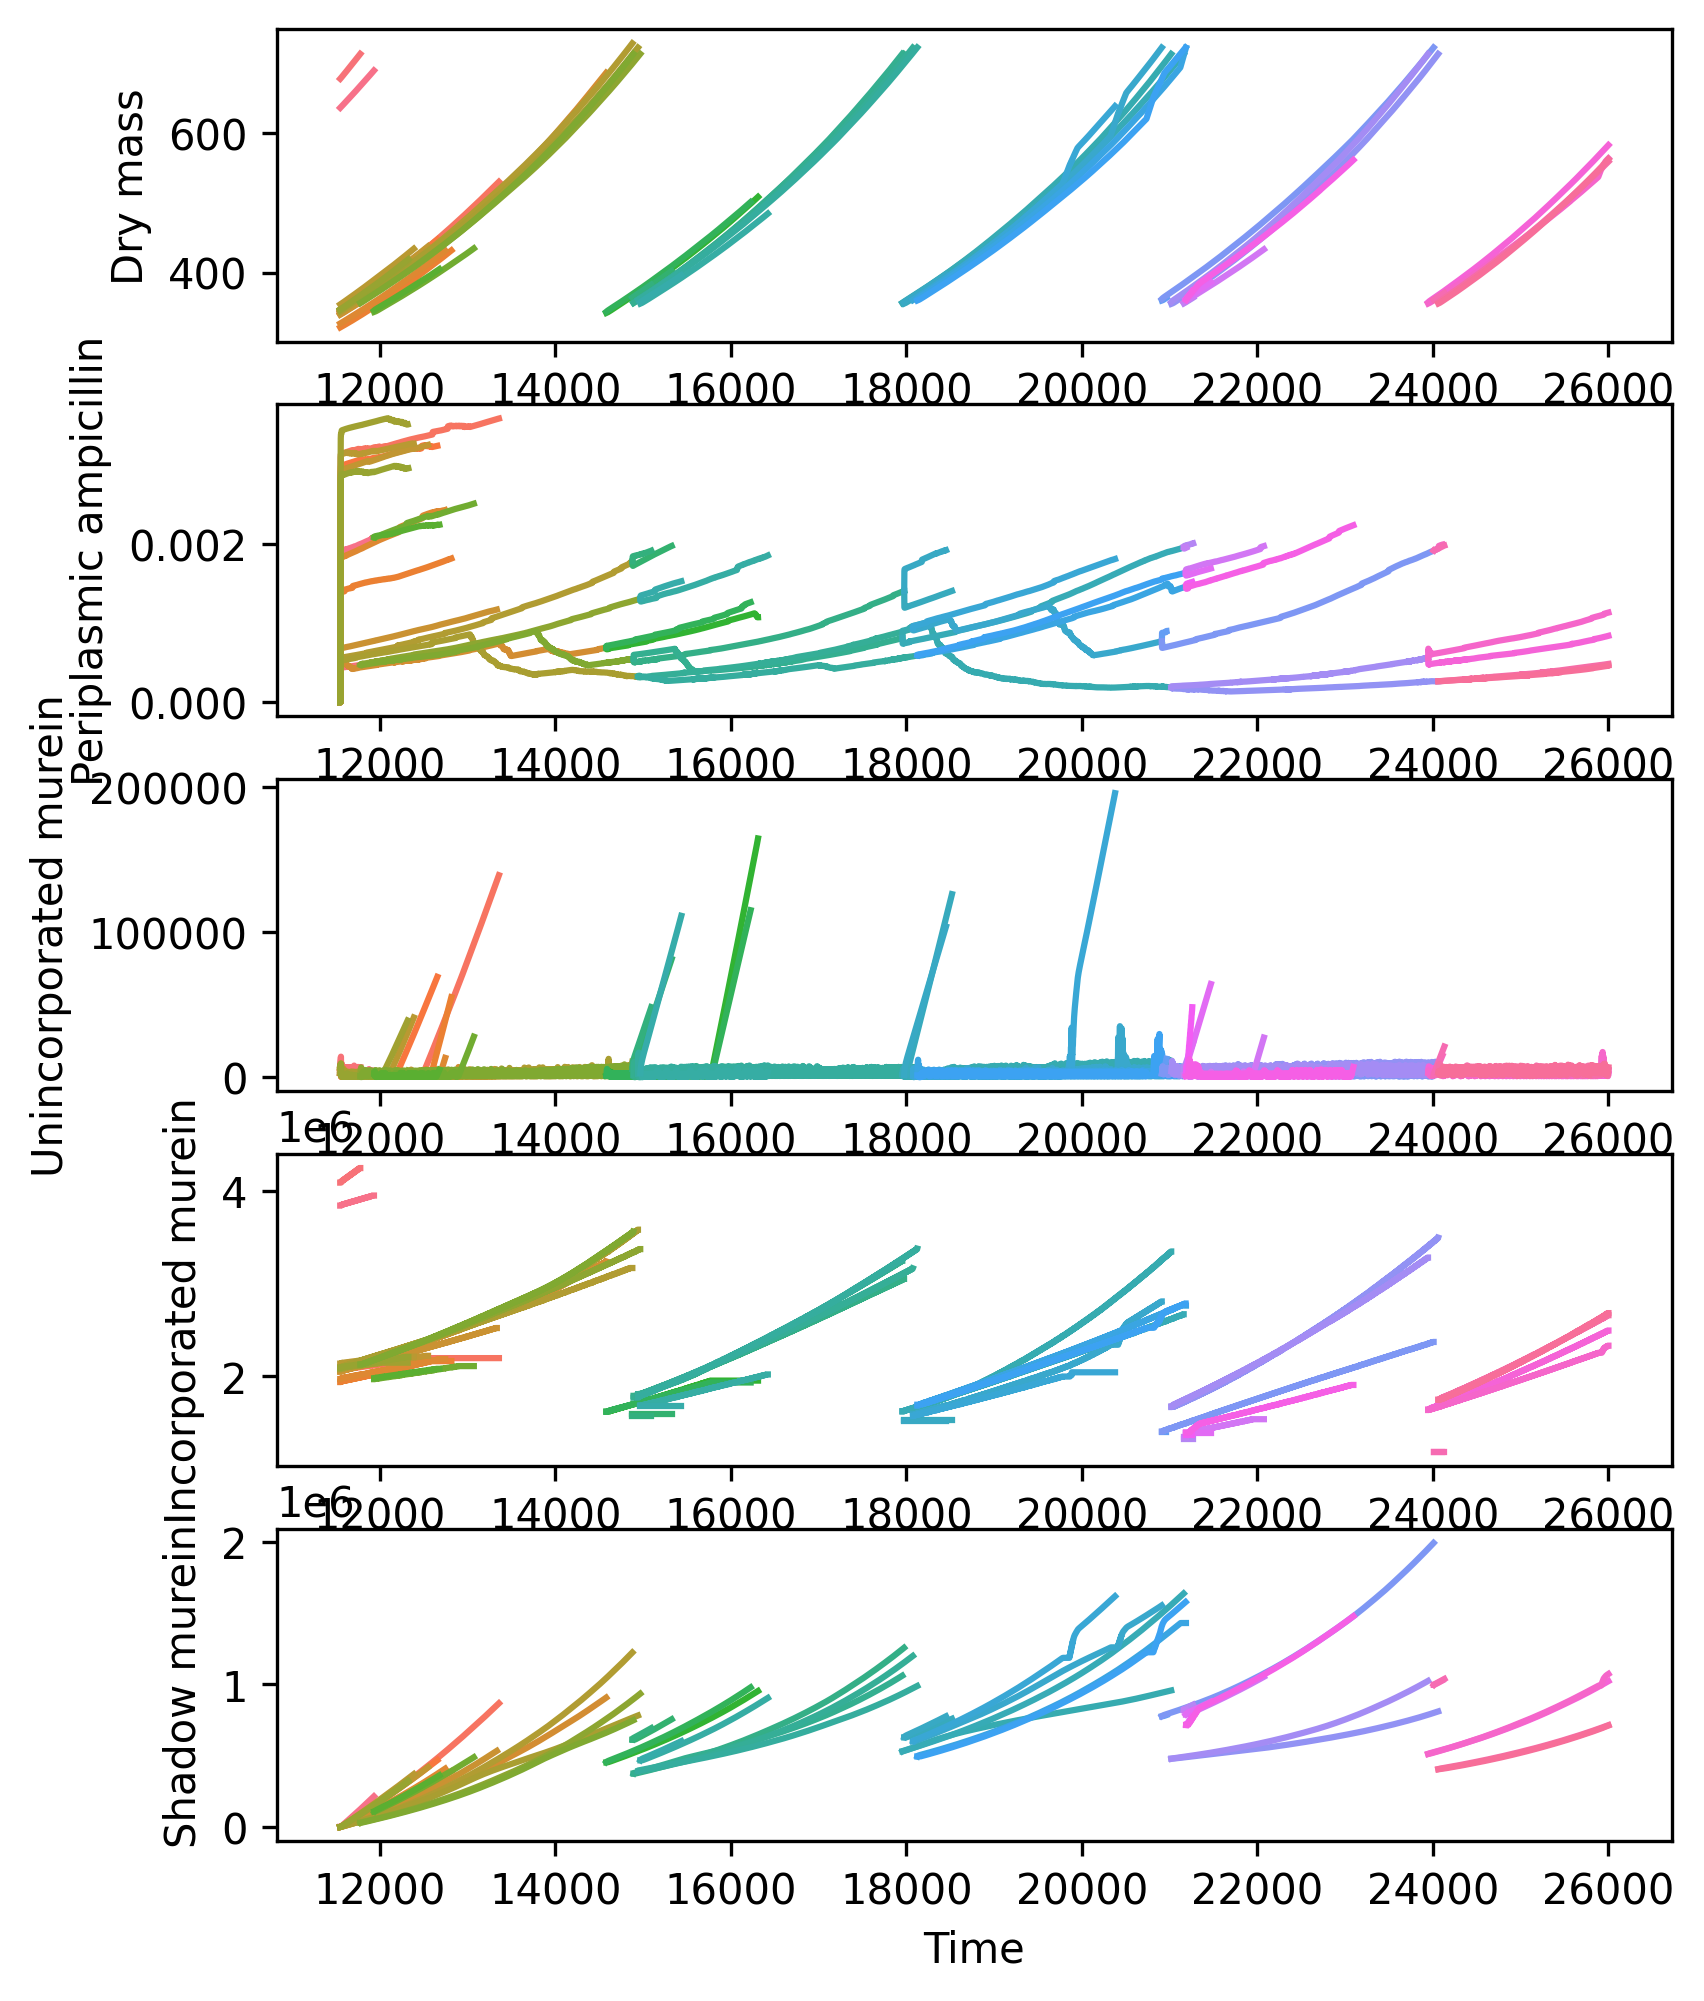

In [3]:
# Multigen timeseries plots

bulk_vars = [
    "Dry mass",
    "Periplasmic ampicillin",
    "Unincorporated murein",
    "Incorporated murein",
    "Shadow murein",
]

def plot_timeseries(y_vars, data):
    fig, axs = plt.subplots(len(y_vars), 1)

    for var, ax in zip(y_vars, axs):
        sns.lineplot(
            x="Time",
            y=var,
            hue="Agent ID",
            legend=False,
            data=data,
            ax=ax,
        )
        ax.set_ylabel(var)

    fig.set_size_inches(6, 8)
    return fig

plot_timeseries(bulk_vars, data[data["Time"] != 26002])


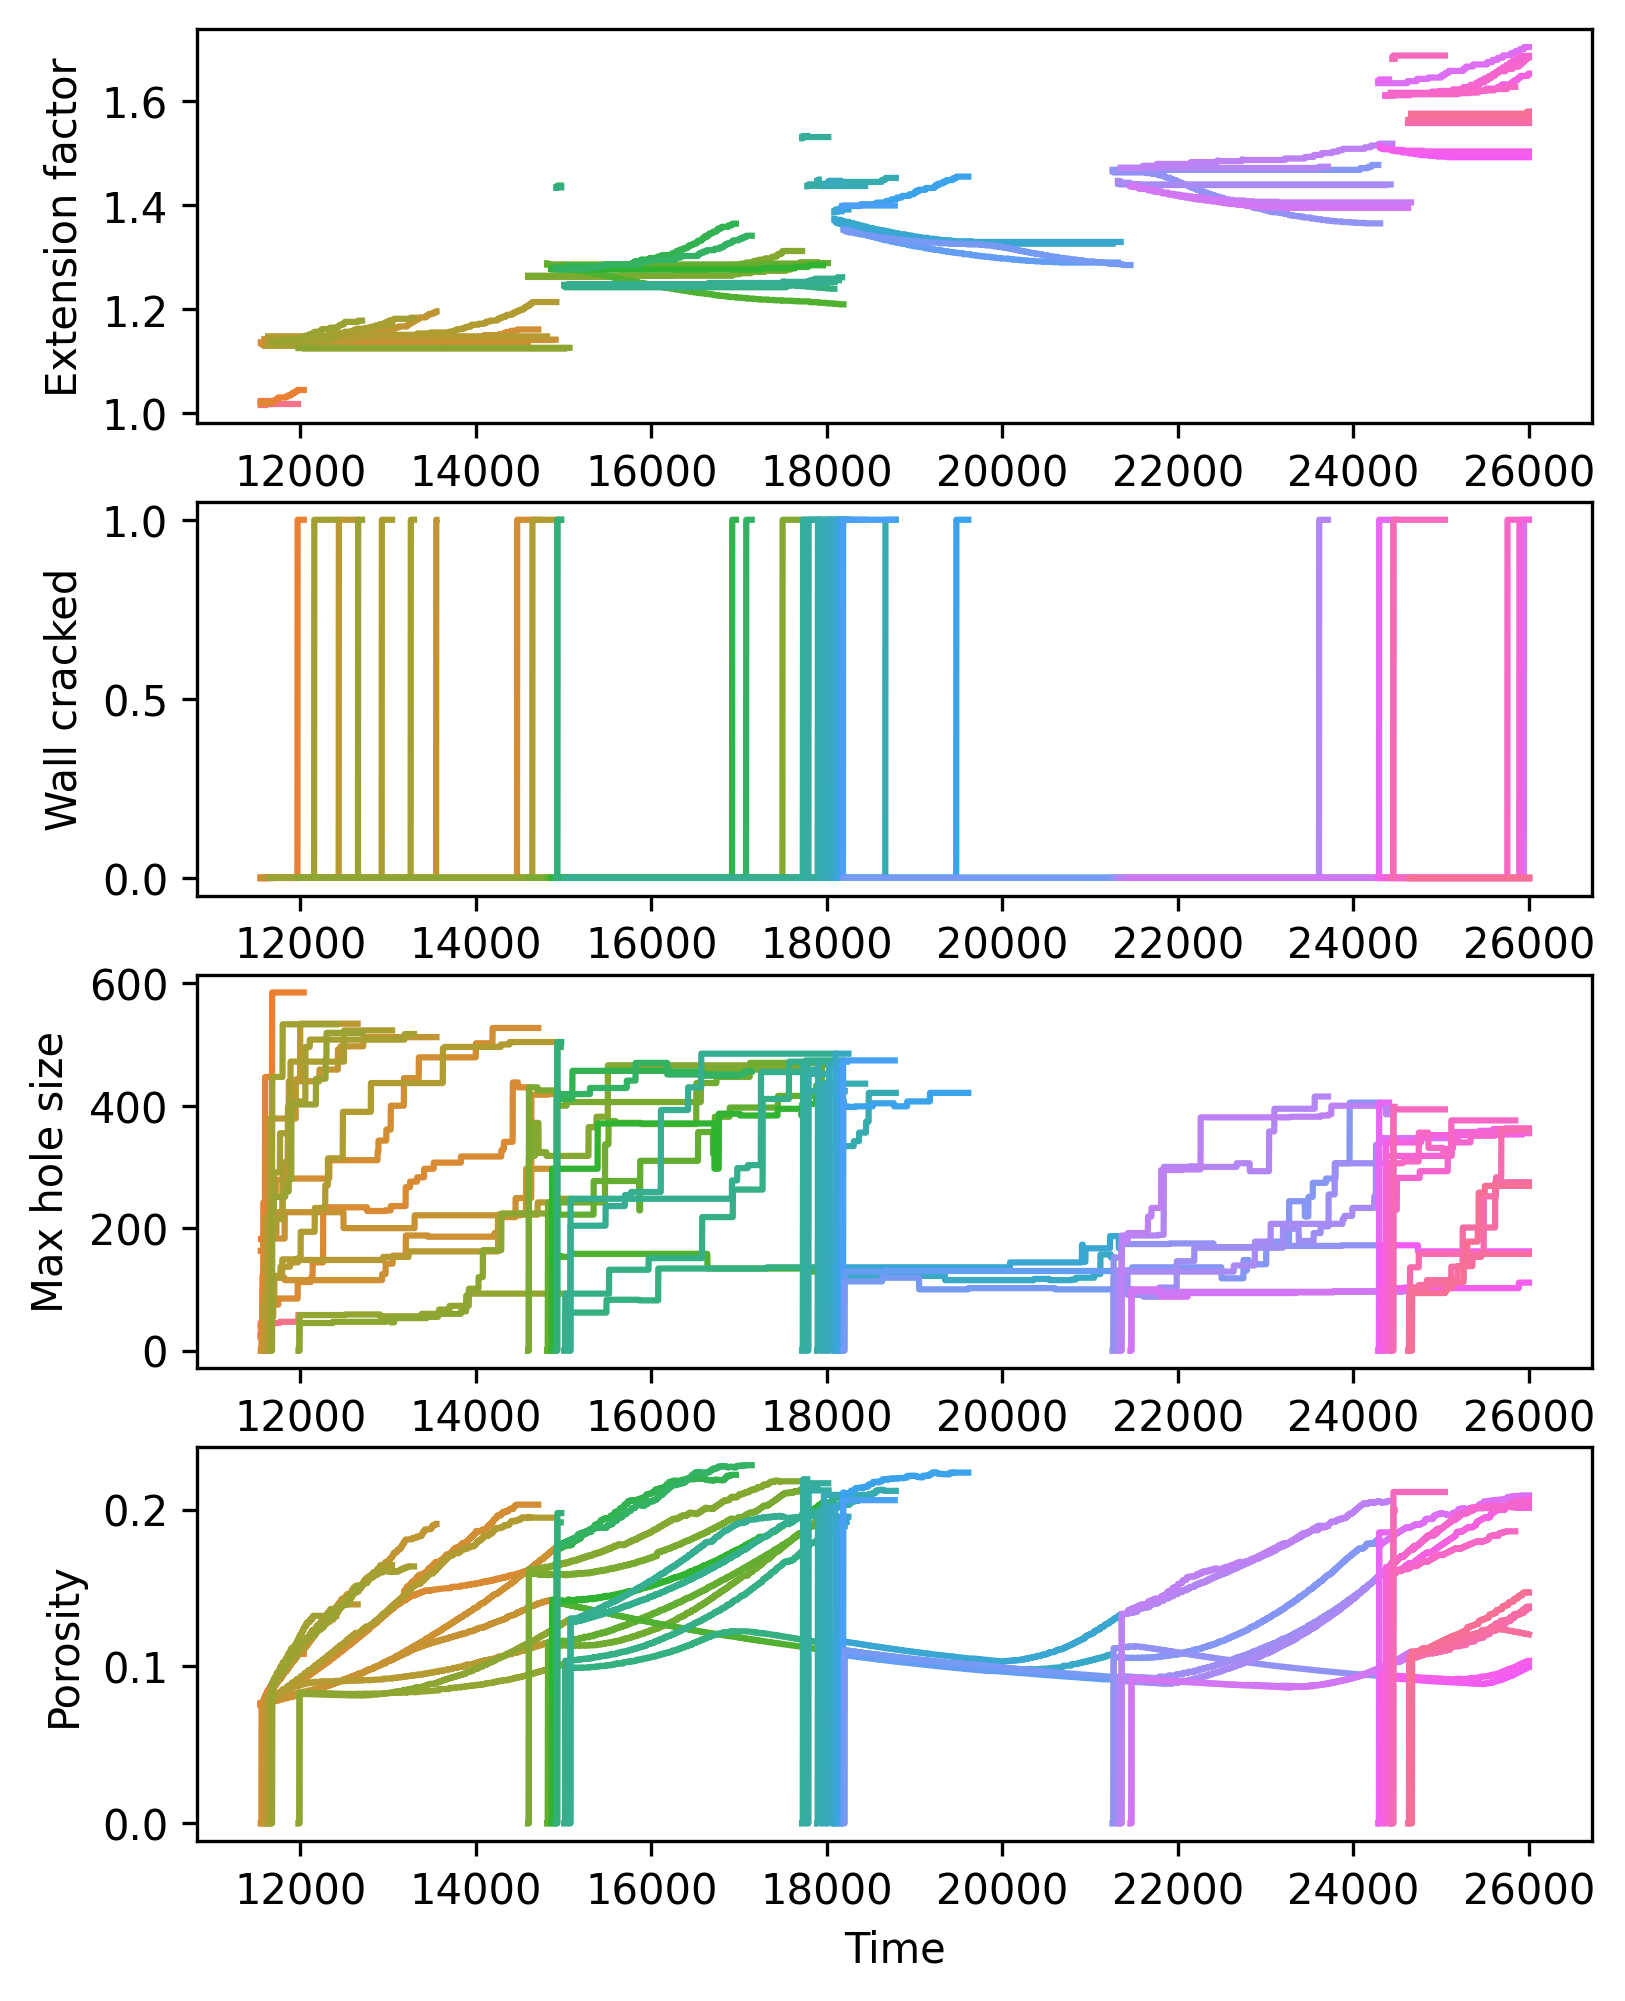

In [5]:
wall_vars = ["Extension factor", "Wall cracked", "Max hole size", "Porosity"]

plot_timeseries(wall_vars, data[data["Time"] != 26002])

In [4]:
# Figure out which cells died

def died(lineage, agent_ids):
    d1, d2 = lineage + "0", lineage + "1"
    return (d1 not in agent_ids) and (d2 not in agent_ids)

unique_ids = data["Agent ID"].unique()
dead_ids = list(filter(lambda id: died(id, unique_ids), unique_ids))
time_of_death = {id: data["Time"][data["Agent ID"] == id].max() for id in dead_ids}

# Remove cells still present at sim end from dead
time_of_death = {id: time for id, time in time_of_death.items() if time != 26002}
dead_ids = list(time_of_death.keys())

data["Died"] = data["Agent ID"].isin(dead_ids)
data["Time of Death"] = data["Agent ID"].map(lambda id: time_of_death.get(id, None))

print(len(dead_ids))
data["Died"].sum() / len(data["Died"])

33


0.3839590443686007

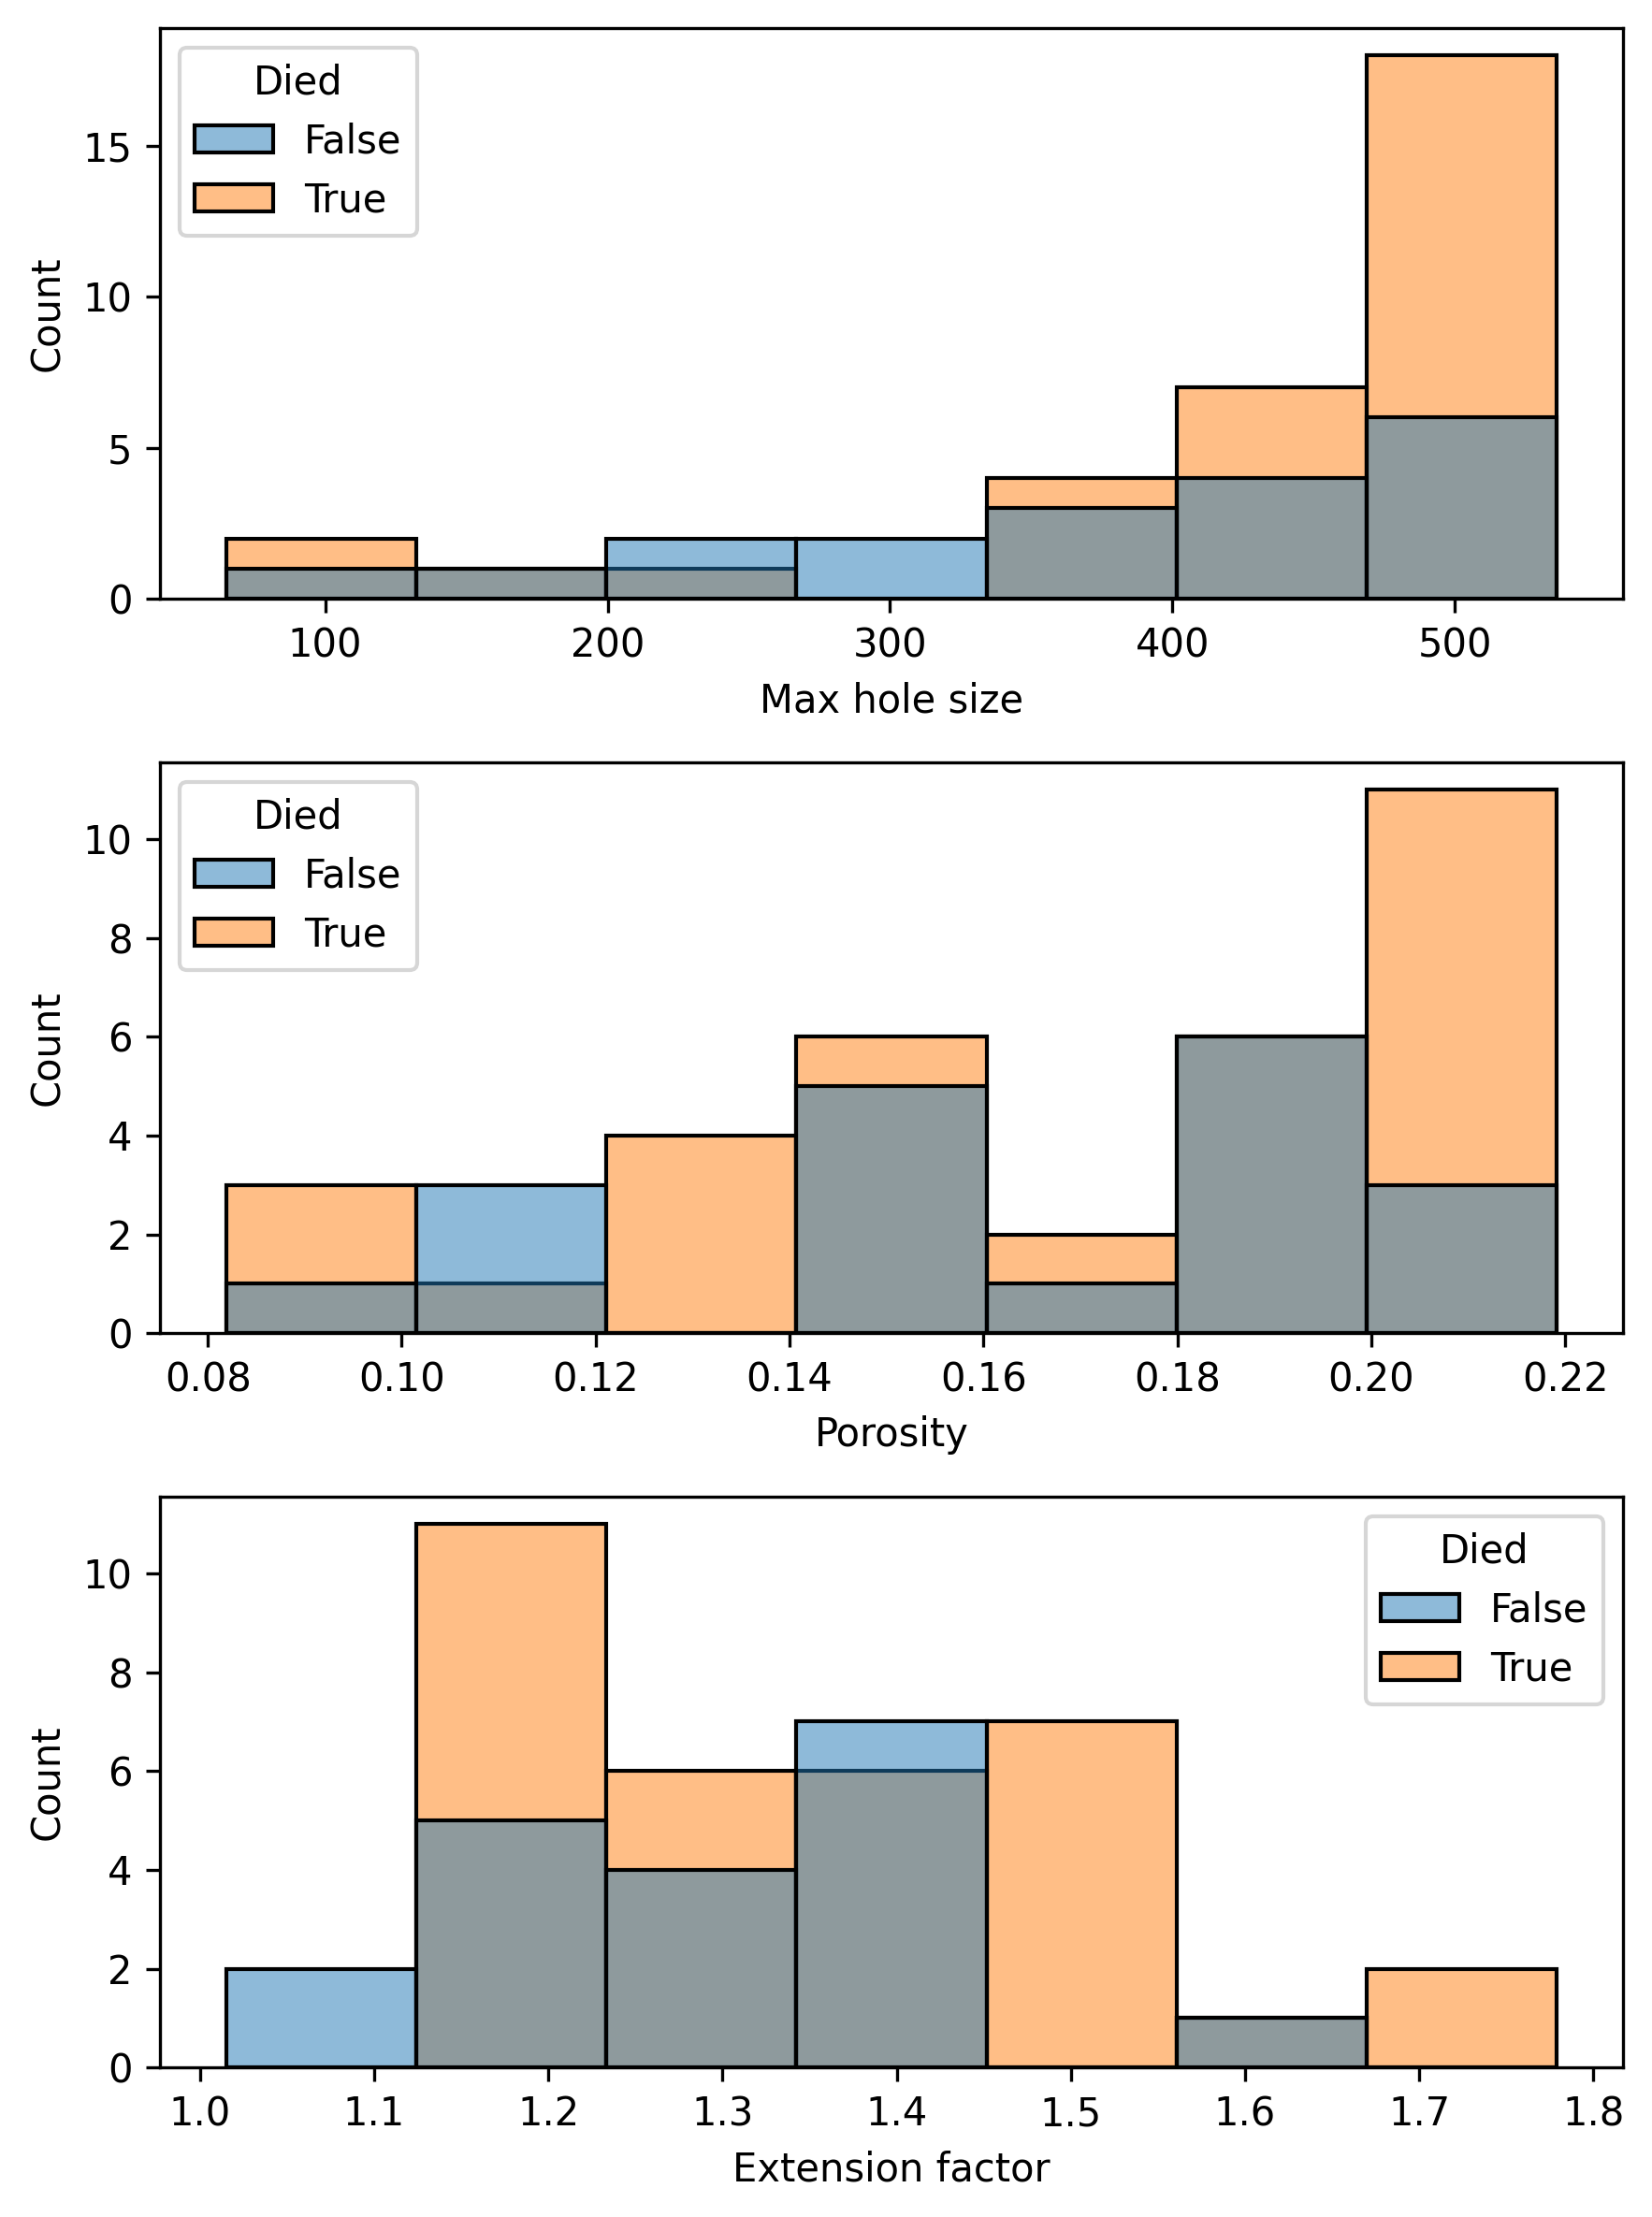

In [5]:
death_factors = ["Max hole size", "Porosity", "Extension factor"]

fig, axs = plt.subplots(len(death_factors), 1)

for factor, ax in zip(death_factors, axs):
    sns.histplot(
        x=factor,
        hue="Died",
        data=pd.concat(
            [
                data.groupby("Agent ID")[factor].max(),
                data.groupby("Agent ID")[["Died"]].max(),
            ],
            axis=1,
        ),
        ax=ax,
    )

fig.set_size_inches(6, 8)
fig.tight_layout()
fig


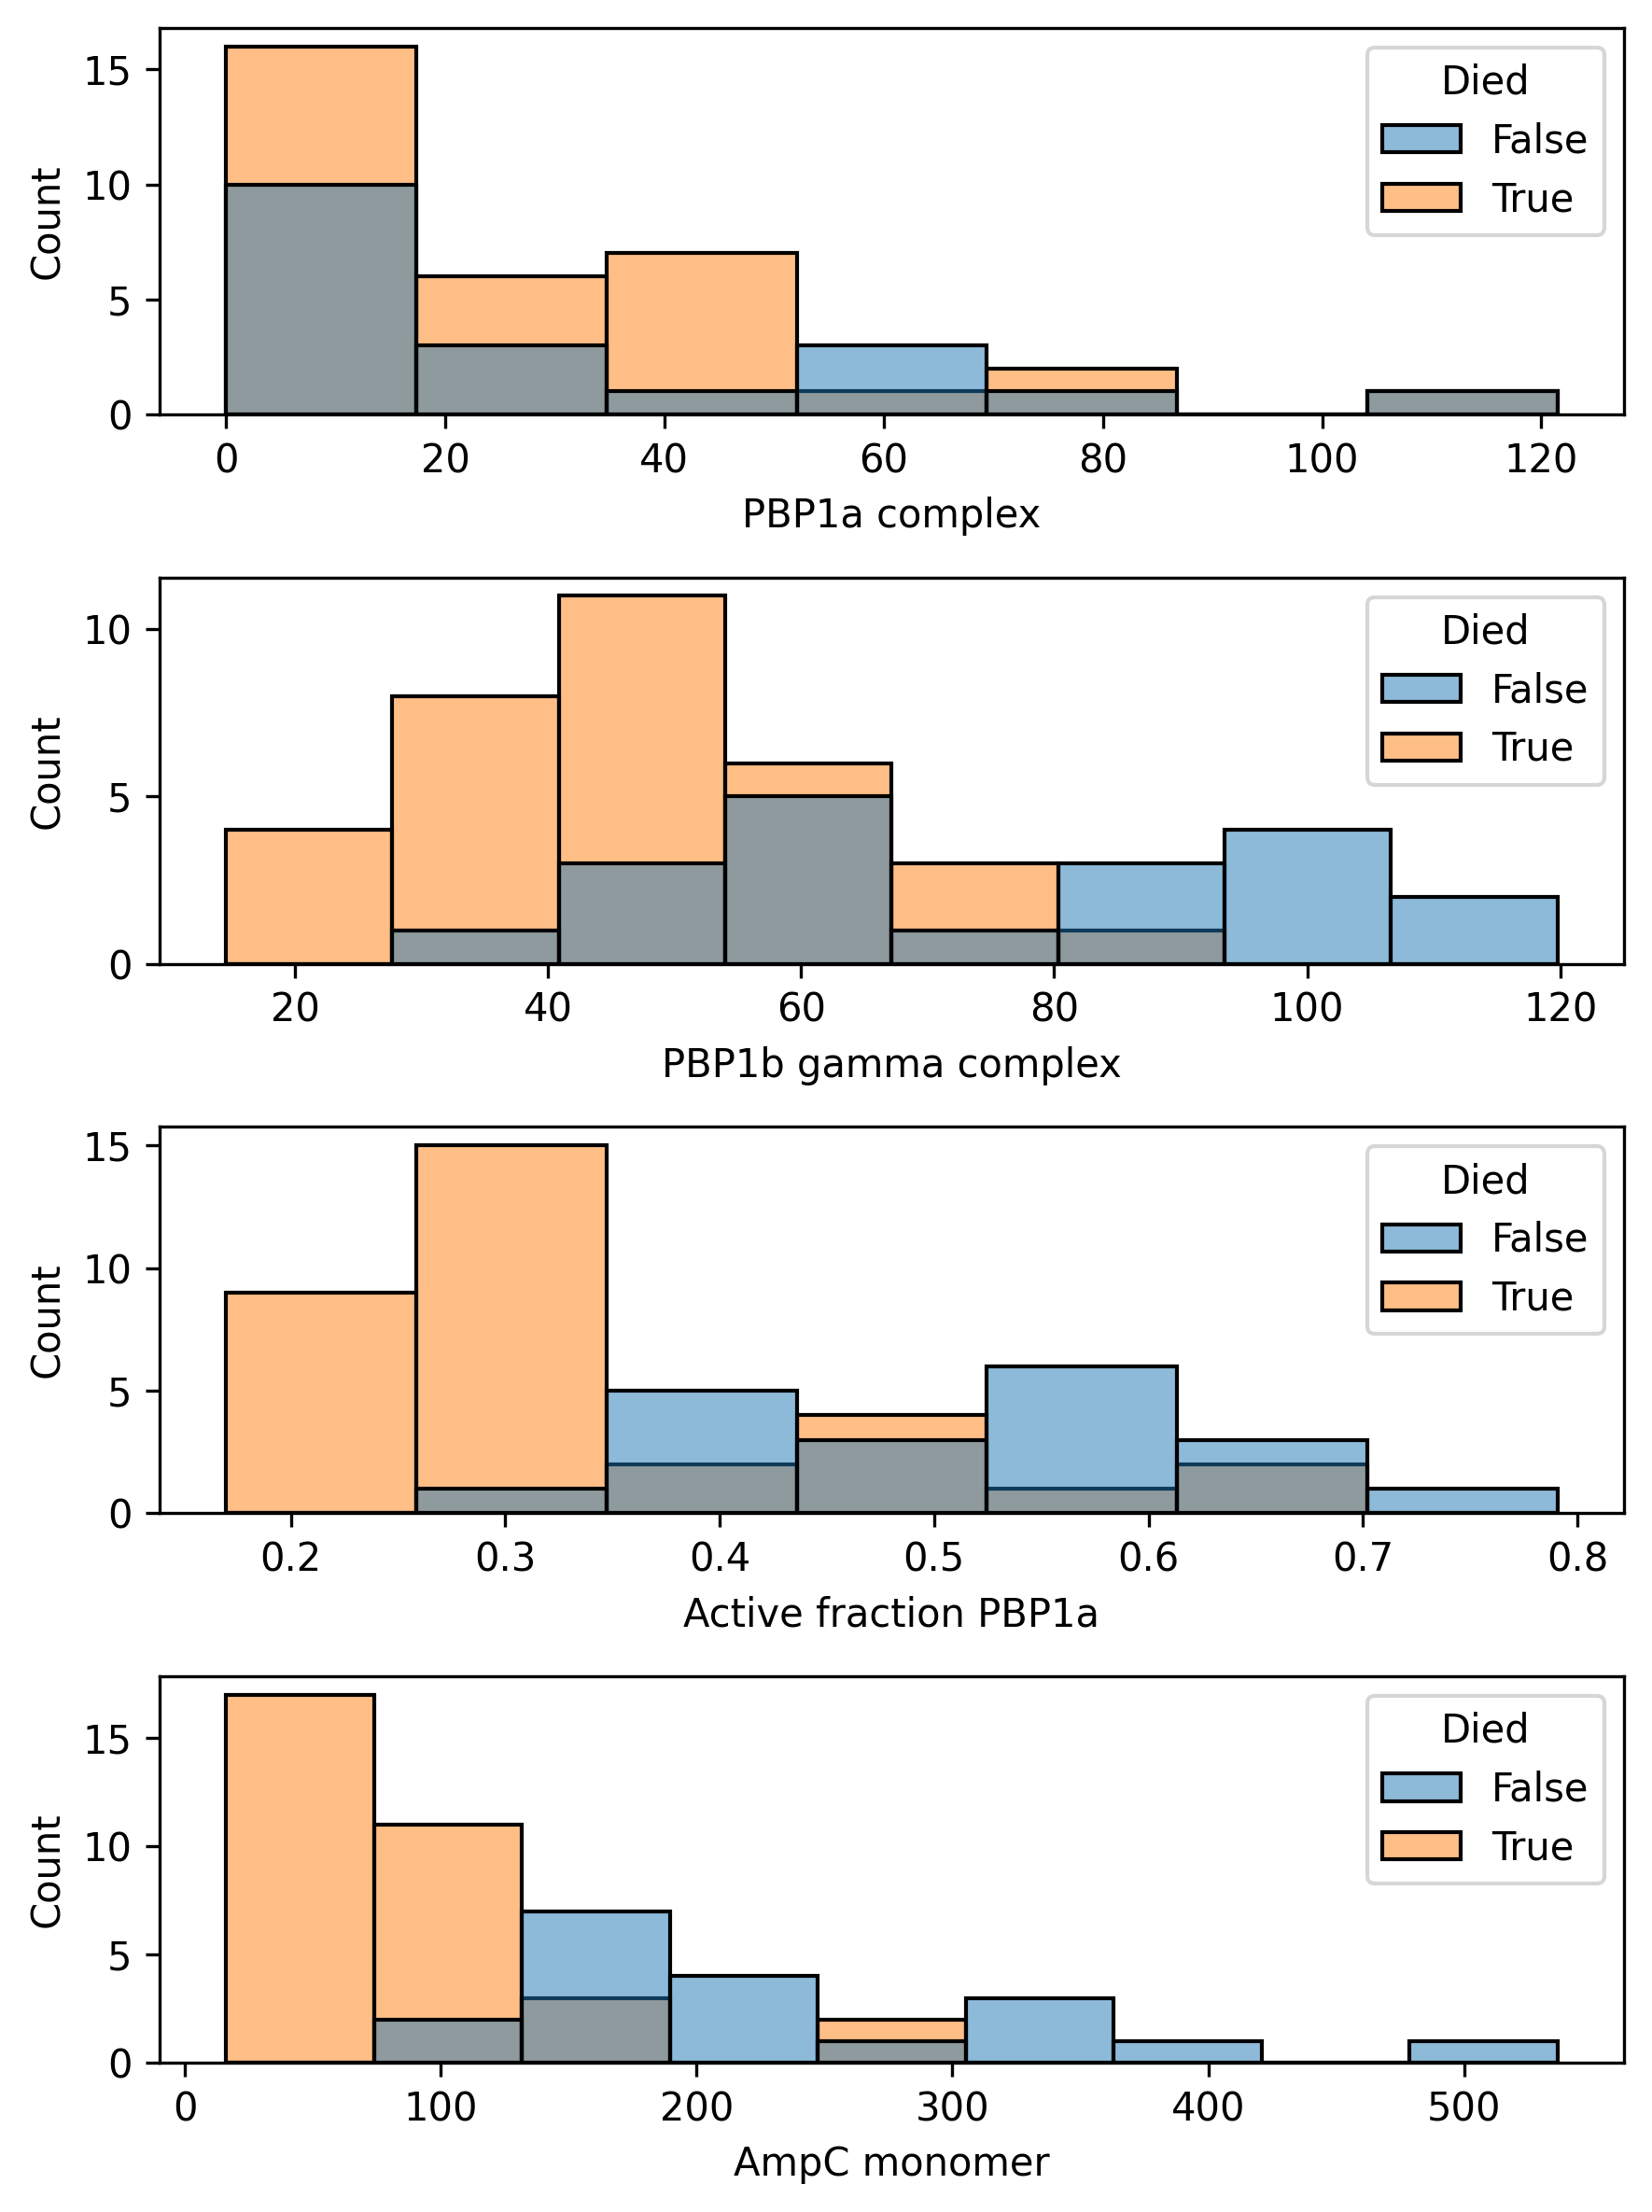

In [6]:
death_factors = [
    "PBP1a complex",
    "PBP1b gamma complex",
    "Active fraction PBP1a",
    "AmpC monomer",
]

fig, axs = plt.subplots(len(death_factors), 1)

for factor, ax in zip(death_factors, axs):
    sns.histplot(
        x=factor,
        hue="Died",
        data=pd.concat(
            [
                data.groupby("Agent ID")[factor].mean(),
                data.groupby("Agent ID")[["Died"]].max(),
            ],
            axis=1,
        ),
        ax=ax,
    )

fig.set_size_inches(6, 8)
fig.tight_layout()
fig


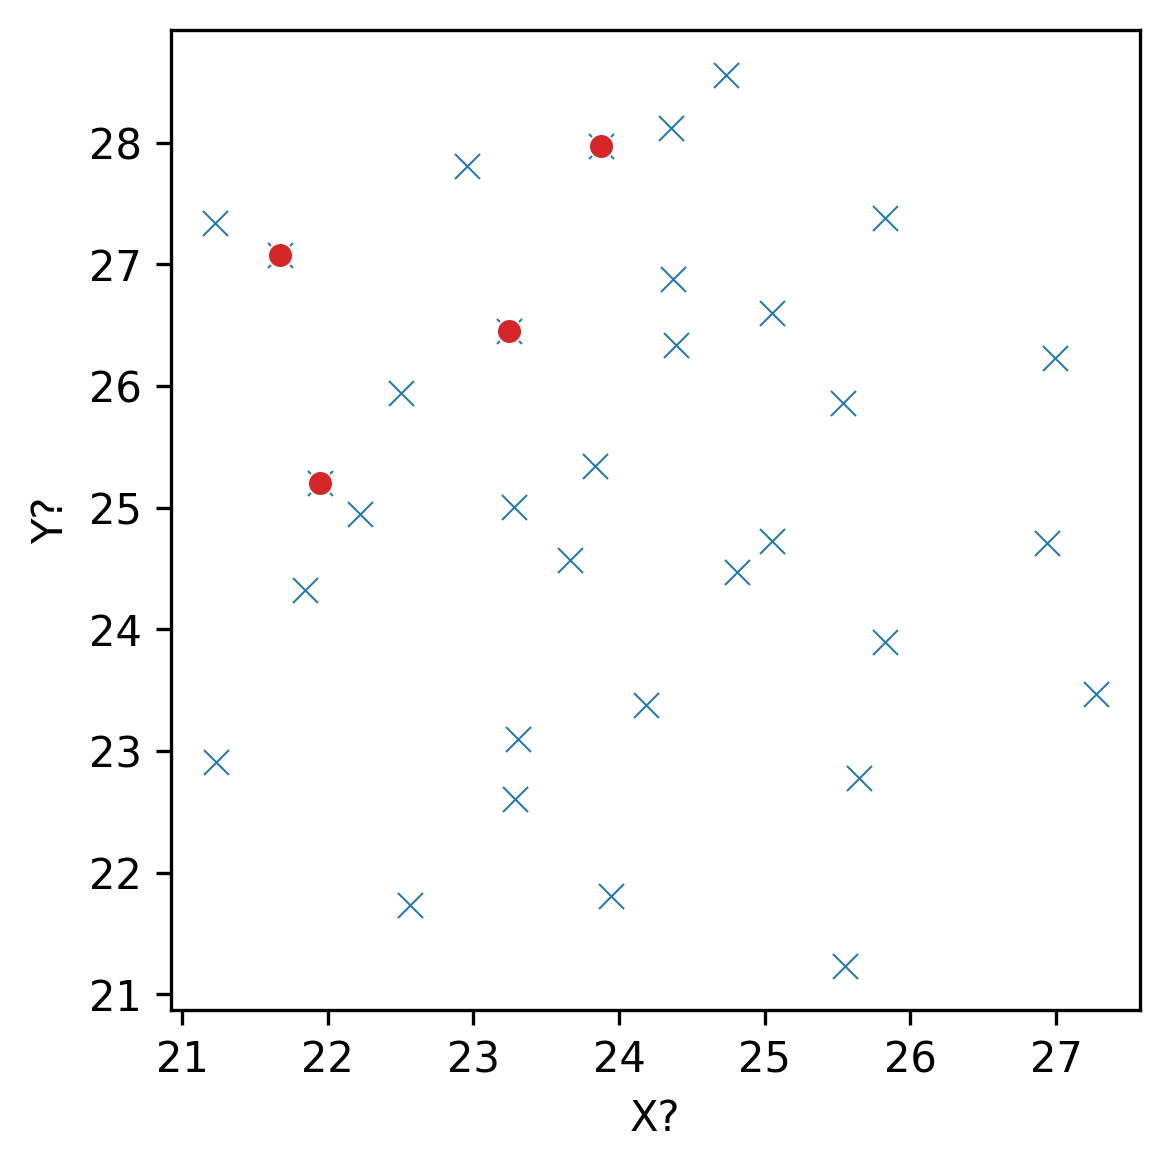

In [7]:
data["X?"] = data["Boundary"].map(lambda b: b["location"][0])
data["Y?"] = data["Boundary"].map(lambda b: b["location"][1])


fig, ax = plt.subplots()

for id, time in time_of_death.items():
    sns.scatterplot(
        x="X?",
        y="Y?",
        style="Died",
        markers=["x"],
        hue="Died",
        legend=False,
        data=data[(data["Agent ID"] == id) & (data["Time"] == time)],
        ax=ax,
    )

sns.scatterplot(x="X?", y="Y?", data=data[data["Time"] == 26000], ax=ax)

fig.set_size_inches(4,4)
fig.tight_layout()
fig

# TODO: plot ampicillin fields

In [10]:
data.columns

Index(['Agent ID', 'Dry mass', 'Growth rate', 'AcrAB-TolC',
       'Periplasmic tetracycline', 'Cytoplasmic tetracycline',
       'Periplasmic ampicillin', 'Active MarR', 'Inactive MarR',
       'micF-ompF duplex', 'Inactive 30S subunit', 'Active ribosomes',
       'Outer tet. permeability (cm/s)', 'Murein tetramer', 'PBP1a complex',
       'PBP1a mRNA', 'PBP1b alpha complex', 'PBP1b mRNA',
       'PBP1b gamma complex', 'Wall cracked', 'AmpC monomer', 'ampC mRNA',
       'Extension factor', 'Wall columns', 'Unincorporated murein',
       'Incorporated murein', 'Shadow murein', 'Max hole size', 'Porosity',
       'Active fraction PBP1a', 'Active fraction PBP1b', 'Boundary', 'Volume',
       'marA mRNA', 'MarA monomer', 'soxS mRNA', 'SoxS monomer', 'yhiV mRNA',
       'YhiV monomer', 'marR mRNA', 'MarR monomer', 'ompR mRNA',
       'OmpR monomer', 'ompF mRNA', 'OmpF monomer', 'envZ mRNA',
       'EnvZ monomer', 'tehA mRNA', 'TehA monomer', 'acrA mRNA',
       'AcrA monomer', 'acrB mRNA',

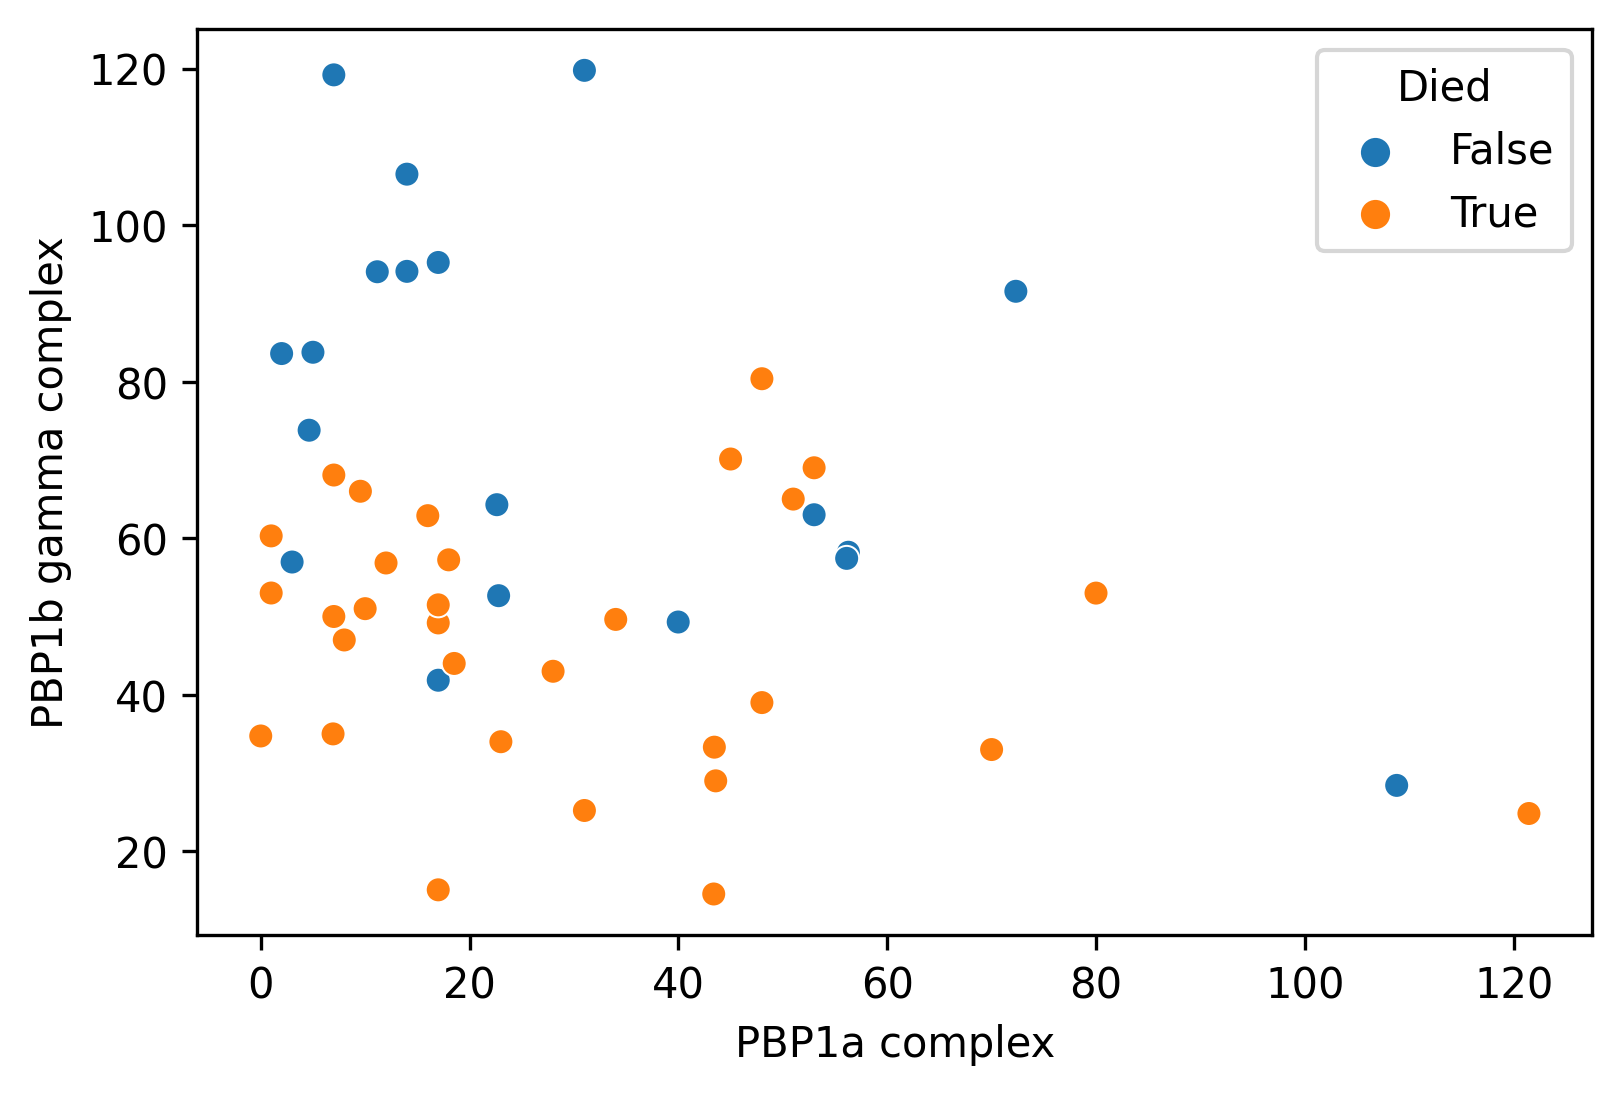

In [8]:
fig, ax = plt.subplots()

sns.scatterplot(
    x="PBP1a complex",
    y="PBP1b gamma complex",
    hue="Died",
    data=pd.concat(
        [
            data.groupby("Agent ID")[["PBP1a complex", "PBP1b gamma complex"]].mean(),
            data.groupby("Agent ID")[["Died"]].max(),
        ],
        axis=1,
    ),
    ax=ax,
)

fig


In [9]:
mean_cols = [
    "Dry mass",
    "Growth rate",
    "AcrAB-TolC",
    "Periplasmic ampicillin",
    "Active ribosomes",
    "Murein tetramer",
    "PBP1a complex",
    "PBP1a mRNA",
    "PBP1b alpha complex",
    "PBP1b mRNA",
    "PBP1b gamma complex",
    "Wall cracked",
    "AmpC monomer",
    "ampC mRNA",
    "Unincorporated murein",
    "Incorporated murein",
    "Shadow murein",
    "Active fraction PBP1a",
    "Active fraction PBP1b",
    "Volume",
]

max_cols = ["Extension factor", "Wall columns", "Max hole size", "Porosity", "Died"]

agent_summary_data = pd.concat(
    [
        data.groupby("Agent ID")[mean_cols].mean(),
        data.groupby("Agent ID")[max_cols].max(),
    ],
    axis=1,
)


In [13]:
agent_summary_data.columns

Index(['Dry mass', 'Growth rate', 'AcrAB-TolC', 'Periplasmic ampicillin',
       'Active ribosomes', 'Murein tetramer', 'PBP1a complex', 'PBP1a mRNA',
       'PBP1b alpha complex', 'PBP1b mRNA', 'PBP1b gamma complex',
       'AmpC monomer', 'ampC mRNA', 'Unincorporated murein',
       'Incorporated murein', 'Shadow murein', 'Active fraction PBP1a',
       'Active fraction PBP1b', 'Volume', 'Extension factor', 'Wall columns',
       'Max hole size', 'Porosity', 'Died'],
      dtype='object')

In [14]:
fig = sns.pairplot(data=agent_summary_data, hue="Died")
fig

In [15]:
import umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()

scaled_summary_data = StandardScaler().fit_transform(agent_summary_data.drop("Died").values)

embedding = reducer.fit_transform(scaled_summary_data)
embedding.shape

sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=agent_summary_data.Died)

KeyError: "['Died'] not found in axis"

: 

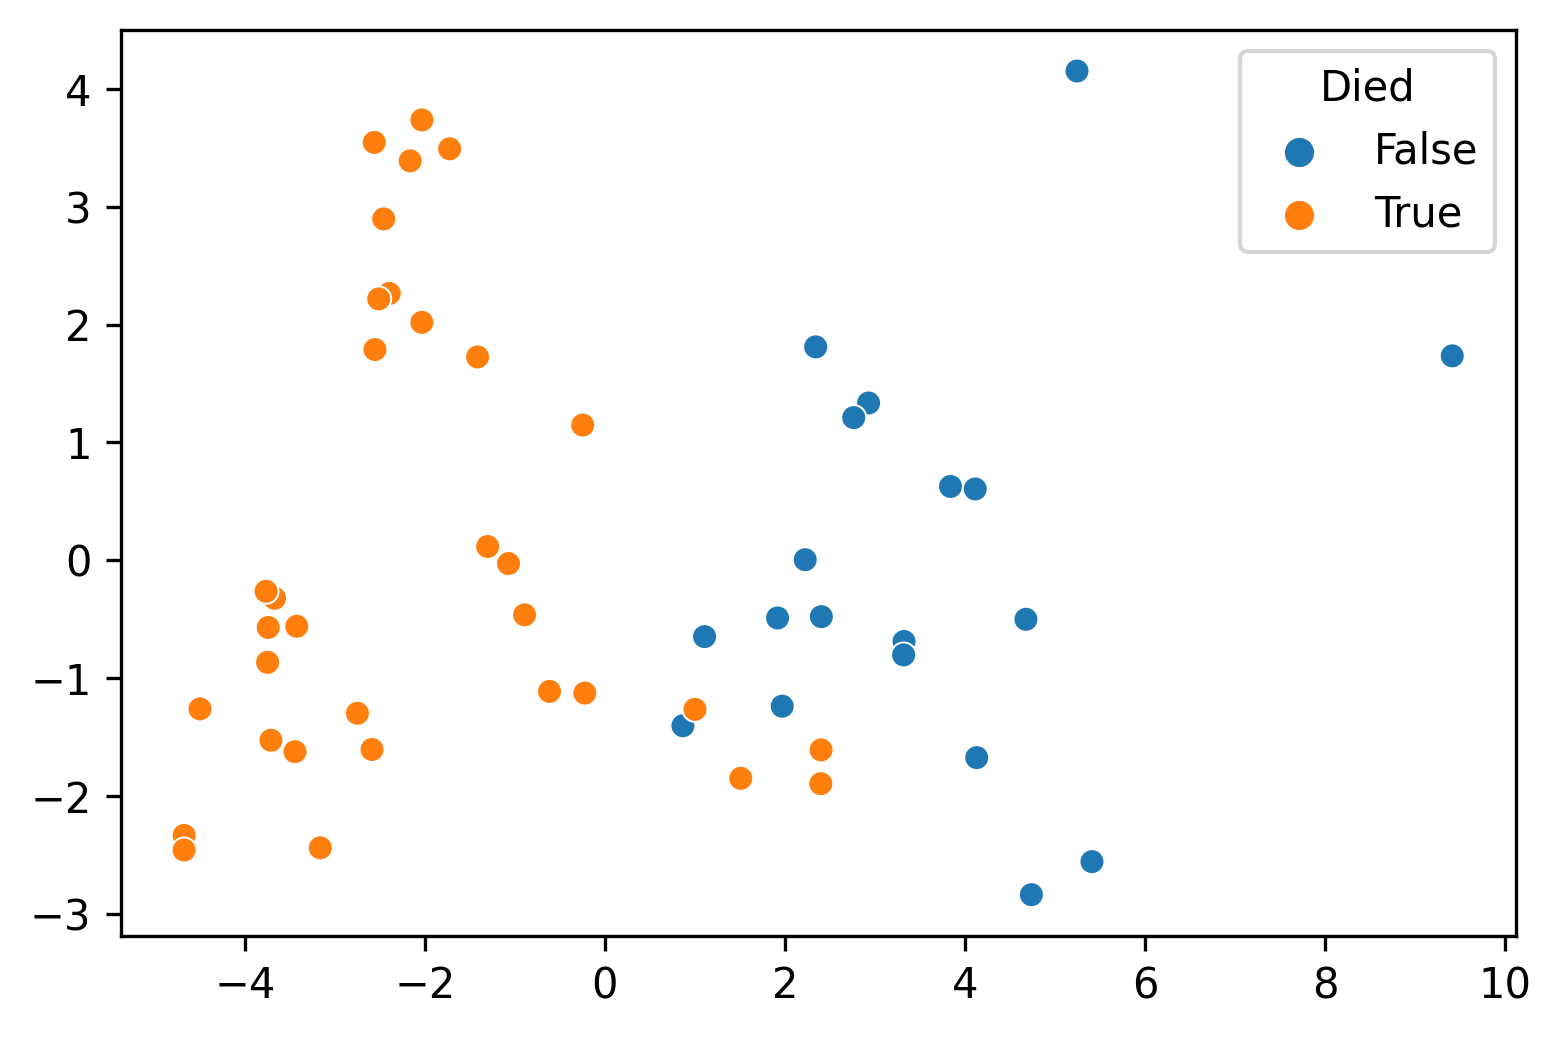

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaled_summary_data = StandardScaler().fit_transform(
    agent_summary_data.drop("Died", axis=1).values
)

pca = PCA(n_components=2)
X_r = pca.fit_transform(scaled_summary_data)

fig, ax = plt.subplots()

sns.scatterplot(
    x=X_r[:, 0],
    y=X_r[:, 1],
    hue=agent_summary_data["Died"],
    ax=ax
)

fig


In [11]:
print(pca.explained_variance_ratio_)

for component in pca.components_:
    print(" + ".join("%.2f x %s" % (value, name) for value, name in zip(component, list(agent_summary_data.drop("Died", axis=1).columns))))
    print()

[0.46128458 0.14613712]
0.29 x Dry mass + 0.24 x Growth rate + 0.22 x AcrAB-TolC + -0.21 x Periplasmic ampicillin + 0.29 x Active ribosomes + 0.28 x Murein tetramer + -0.00 x PBP1a complex + -0.00 x PBP1a mRNA + -0.00 x PBP1b alpha complex + 0.09 x PBP1b mRNA + 0.17 x PBP1b gamma complex + -0.23 x Wall cracked + 0.26 x AmpC monomer + 0.13 x ampC mRNA + -0.15 x Unincorporated murein + 0.26 x Incorporated murein + -0.05 x Shadow murein + 0.24 x Active fraction PBP1a + 0.24 x Active fraction PBP1b + 0.28 x Volume + -0.12 x Extension factor + 0.29 x Wall columns + -0.17 x Max hole size + -0.14 x Porosity

0.03 x Dry mass + -0.00 x Growth rate + 0.07 x AcrAB-TolC + 0.33 x Periplasmic ampicillin + 0.04 x Active ribosomes + 0.03 x Murein tetramer + 0.14 x PBP1a complex + 0.09 x PBP1a mRNA + -0.00 x PBP1b alpha complex + 0.19 x PBP1b mRNA + 0.02 x PBP1b gamma complex + -0.14 x Wall cracked + -0.22 x AmpC monomer + -0.12 x ampC mRNA + -0.09 x Unincorporated murein + 0.26 x Incorporated murein +

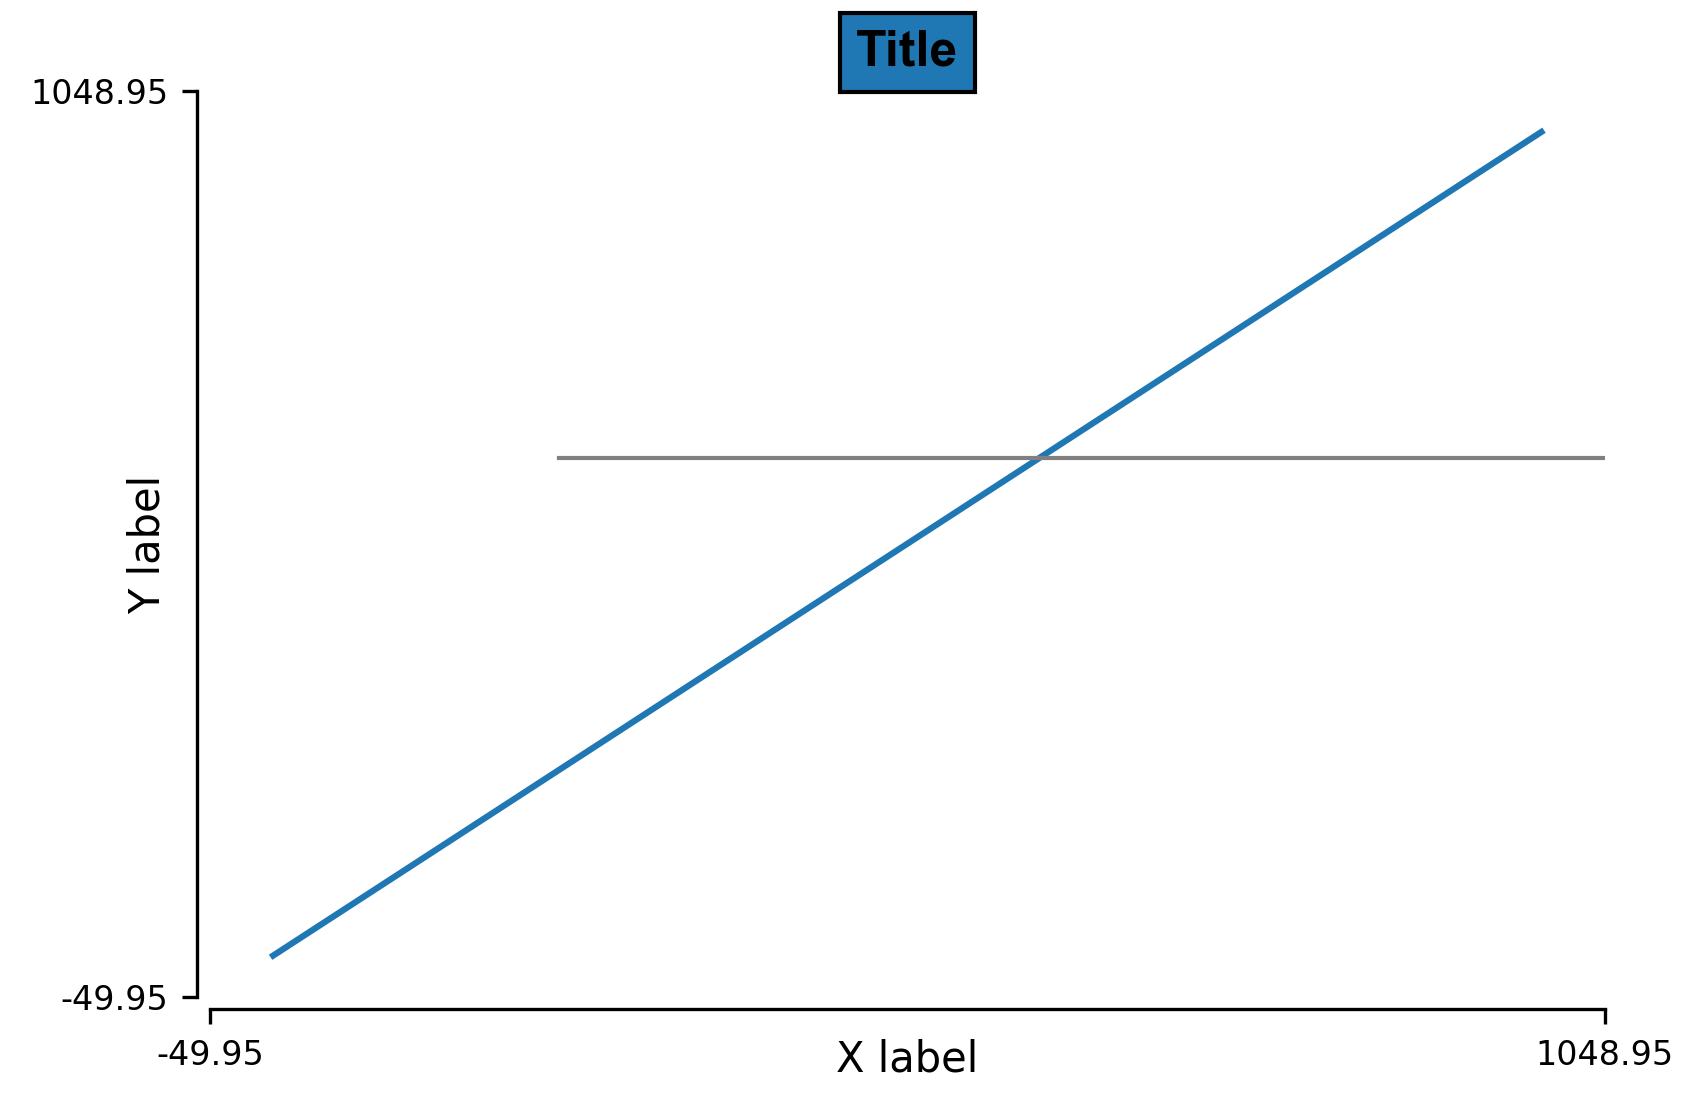

: 

In [ ]:
# Demo: making "pretty axes"


def prettify_axis(ax, title_fontsize=12, label_fontsize=10, ticklabel_fontsize=8):
    # Restrict ticks to only min and max
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xticks([xmin, xmax], labels=[xmin, xmax], fontname="Arial")
    ax.set_yticks([ymin, ymax], labels=[ymin, ymax], fontname="Arial")

    ax.tick_params(which="major", labelsize=ticklabel_fontsize)

    # Move axis titles to middle of axis
    ax.set_xticks(
        [(xmin + xmax) / 2], labels=[ax.get_xlabel()], minor=True, fontname="Arial"
    )
    ax.set_yticks(
        [(ymin + ymax) / 2], labels=[ax.get_ylabel()], minor=True, fontname="Arial"
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    ax.tick_params(
        which="minor",
        width=0,
        length=ax.xaxis.get_major_ticks()[0].get_tick_padding(),
        labelsize=label_fontsize,
    )

    # Despine
    sns.despine(ax=ax, offset=3)

    # Need to rotate y label AFTER despining for inexplicable reasons
    ax.yaxis.get_minor_ticks()[0].label.set(rotation=90, va="center")

    # Format title
    ax.set_title(
        ax.get_title(), fontsize=title_fontsize, fontname="Arial", fontweight="bold"
    )


fig, ax = plt.subplots()

ax.plot(np.arange(1000))
ax.set_xlabel("X label")
ax.set_ylabel("Y label")
ax.set_title("Title")

prettify_axis(ax)

# t_x, t_y = ax.title.get_position()
# f_x, f_y = [1, t_y]
# line = matplotlib.lines.Line2D([t_x, f_x], [t_y, f_y], lw=1, color="0.5")
# fig.add_artist(line)

# x,y = np.array([[0.05, 0.1, 0.9], [0.05, 0.5, 0.9]])
# line = matplotlib.lines.Line2D(x, y, lw=5., color='r', alpha=0.4)

# Get text coordinates
ax.title.set_bbox({})
title_bounds = ax.bbox.bounds

x = [title_bounds[0], title_bounds[0] + title_bounds[2]]
y = [title_bounds[1] + title_bounds[3]/2, title_bounds[1] + title_bounds[3]/2]
line = matplotlib.lines.Line2D(x, y, lw=1, color="0.5")
ax.add_artist(line)

fig

In [ ]:
ax.bbox.bounds

(225.0, 150.0, 1395.0, 906.0)